Robot Dynamic Model Identification
=======
---

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time
np.warnings.filterwarnings('ignore') 

---
# Data processing

In [2]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')

## Load data

In [3]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [4]:
# Names as Arguments
model_name = 'psm'

training_trajectory_name = 'nine'
training_trajectory_name_ = 'onyeditr'

model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,training_trajectory_name_) 


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [5]:
training_trajectory_name = 'nine'
results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results_2.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


### Training trajectory

<Figure size 432x288 with 0 Axes>

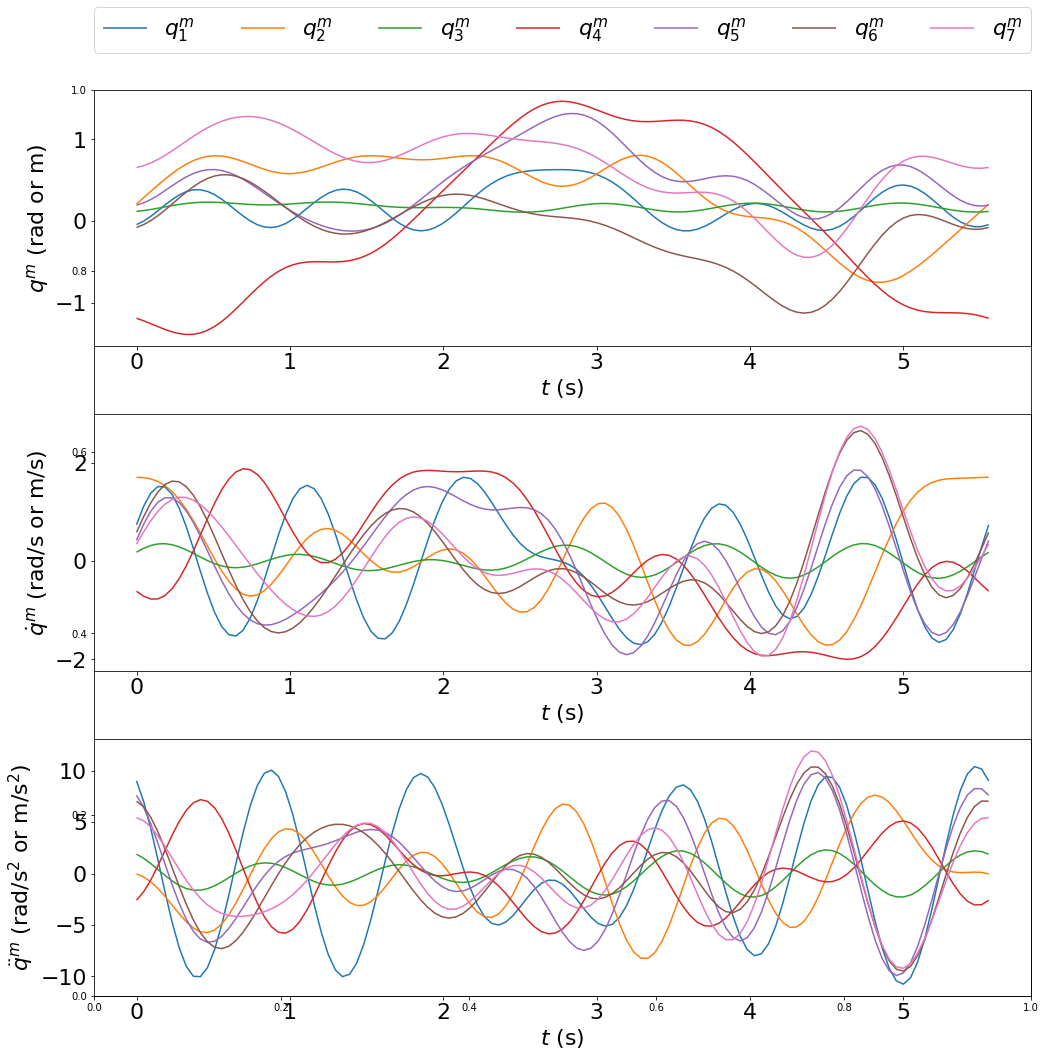

In [6]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
#traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [7]:
test_trajectory_name = 'seven'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results_2.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [8]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

q_raw shape: (5999, 7)
plot shape: 470


<Figure size 432x288 with 0 Axes>

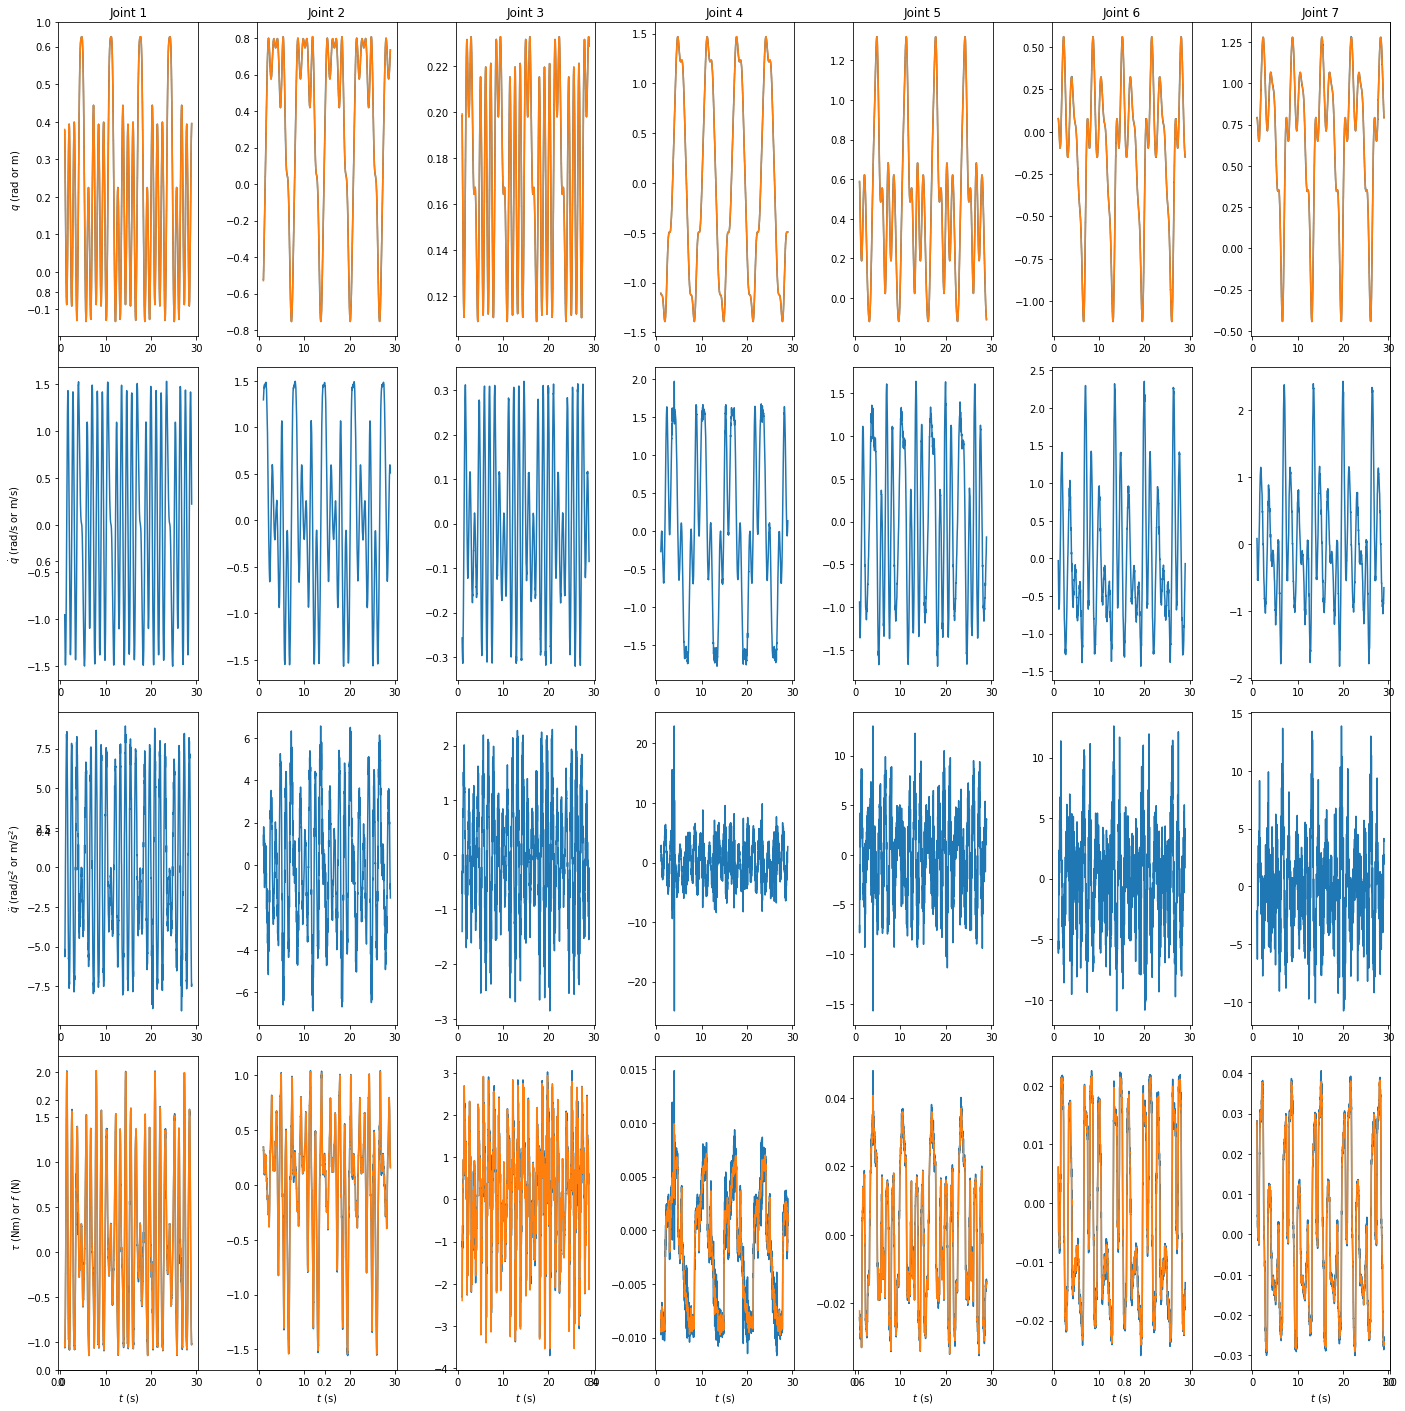

In [9]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (5999, 7)
plot shape: 470


<Figure size 432x288 with 0 Axes>

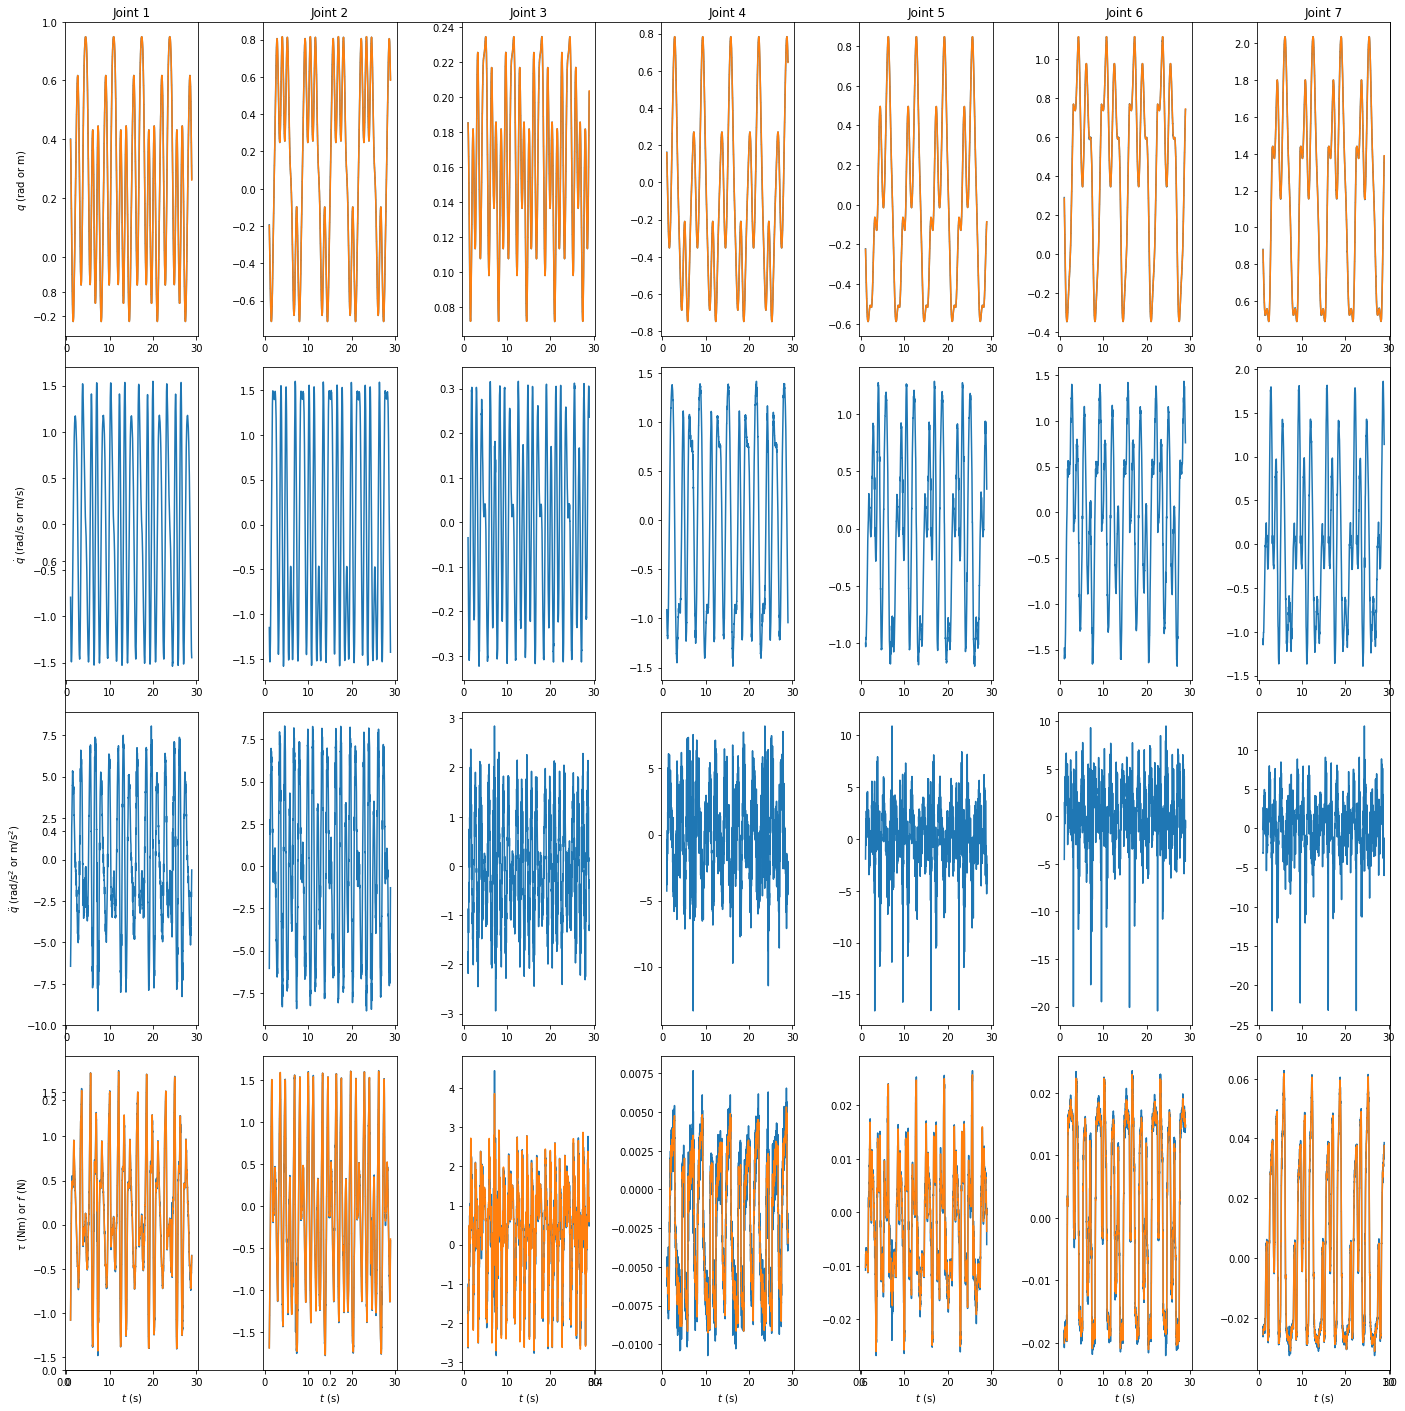

In [10]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [11]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [12]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [13]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

In [14]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 350
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

#display(HTML(tabulate.tabulate(table, tablefmt='html')))

## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [15]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [16]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0005819046181139627
standard deviation of xb using OLS:
[4.03772745e-04 7.22750959e-05 5.64432481e-05 5.45910632e-05
 4.75035669e-05 3.14676352e-04 7.22815300e-05 1.02977126e-04
 6.23917848e-05 1.07934307e-04 5.85731702e-05 9.05070091e-05
 2.68797522e-04 1.12874462e-04 5.54596692e-05 9.92149878e-05
 1.17973125e-04 1.43523657e-02 9.35228947e-05 1.16554337e-04
 1.40721745e-04 7.40006267e-04 1.77149520e-04 4.20203681e-03
 1.02311330e-04 1.10959900e-03 1.67749727e-03 4.27050845e-04
 6.30806492e-02 2.51681376e-03 4.13184295e-03 1.85507756e-03
 7.40879552e-04 1.08875817e-02 5.91321389e-04 5.60947157e-04
 6.41209138e-04 7.67683506e-04 8.41742779e-04 4.17770541e-03
 1.43830662e-02 6.75077890e-04 6.17615970e-04 6.84500964e-04
 5.77970329e-04 5.63795721e-04 5.17029546e-04 6.25504392e-04]
percentage of standard deviation of xb using OLS: 
[6.56937779e-04 1.14601717e-02 1.46381510e-02 8.54940993e-02
 1.91583682e-02 3.64003256e-03 1.64014920e-02 8.89946952e

### Plot measured torque and predicted torque

('Avarage error of joint ', 1, ': ', 0.048792551950055024)
('Avarage error of joint ', 2, ': ', 0.08937957394124359)
('Avarage error of joint ', 3, ': ', 0.18362166111153835)
('Avarage error of joint ', 4, ': ', 0.017377673331690068)
('Avarage error of joint ', 5, ': ', 0.01640652601690562)
('Avarage error of joint ', 6, ': ', 0.004355309783502542)
('Avarage error of joint ', 7, ': ', 0.008146630770390751)
('Avarage of error: ', 0.05258284670076085)


<Figure size 432x288 with 0 Axes>

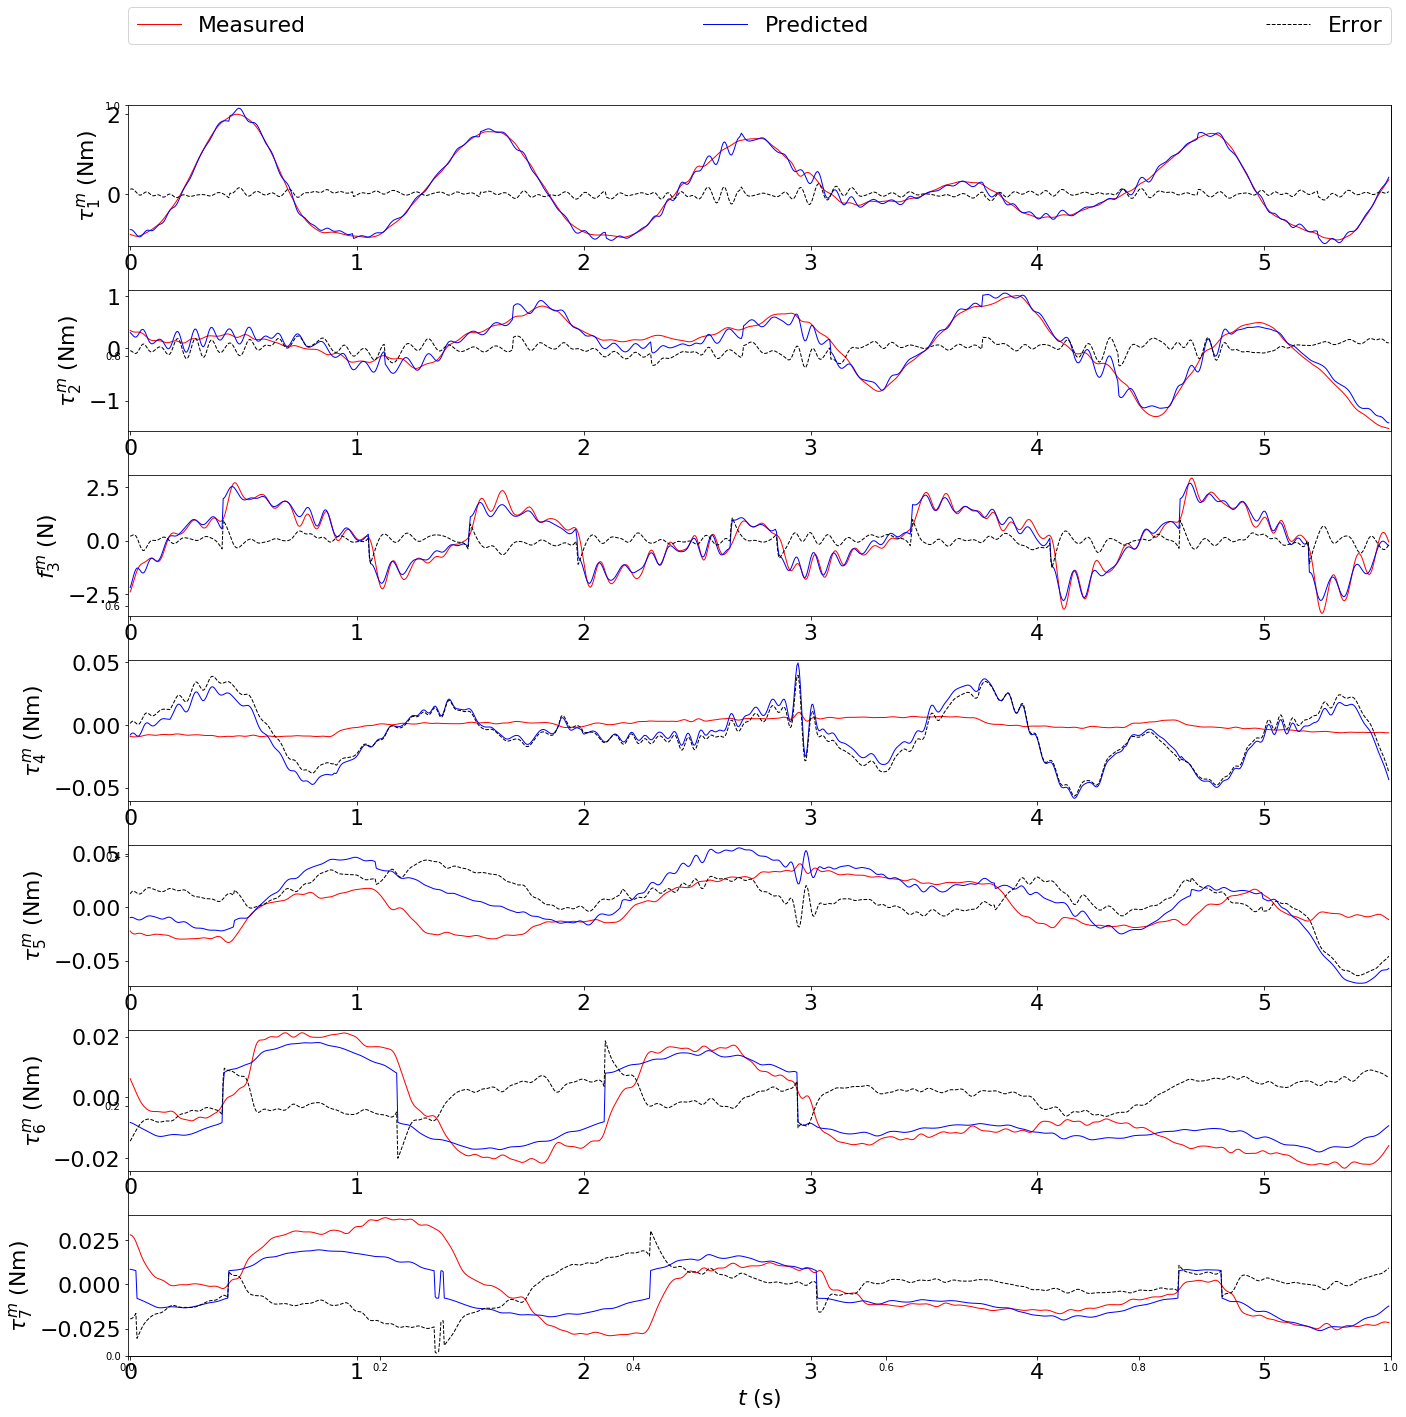

In [17]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [18]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

('Avarage error of joint ', 1, ': ', 0.06473674920736344)
('Avarage error of joint ', 2, ': ', 0.11112910289087638)
('Avarage error of joint ', 3, ': ', 0.2373151817484064)
('Avarage error of joint ', 4, ': ', 0.033434663774861595)
('Avarage error of joint ', 5, ': ', 0.03326874662106533)
('Avarage error of joint ', 6, ': ', 0.00415066263105888)
('Avarage error of joint ', 7, ': ', 0.014655022360579719)
('Avarage of error: ', 0.07124144703345882)


<Figure size 432x288 with 0 Axes>

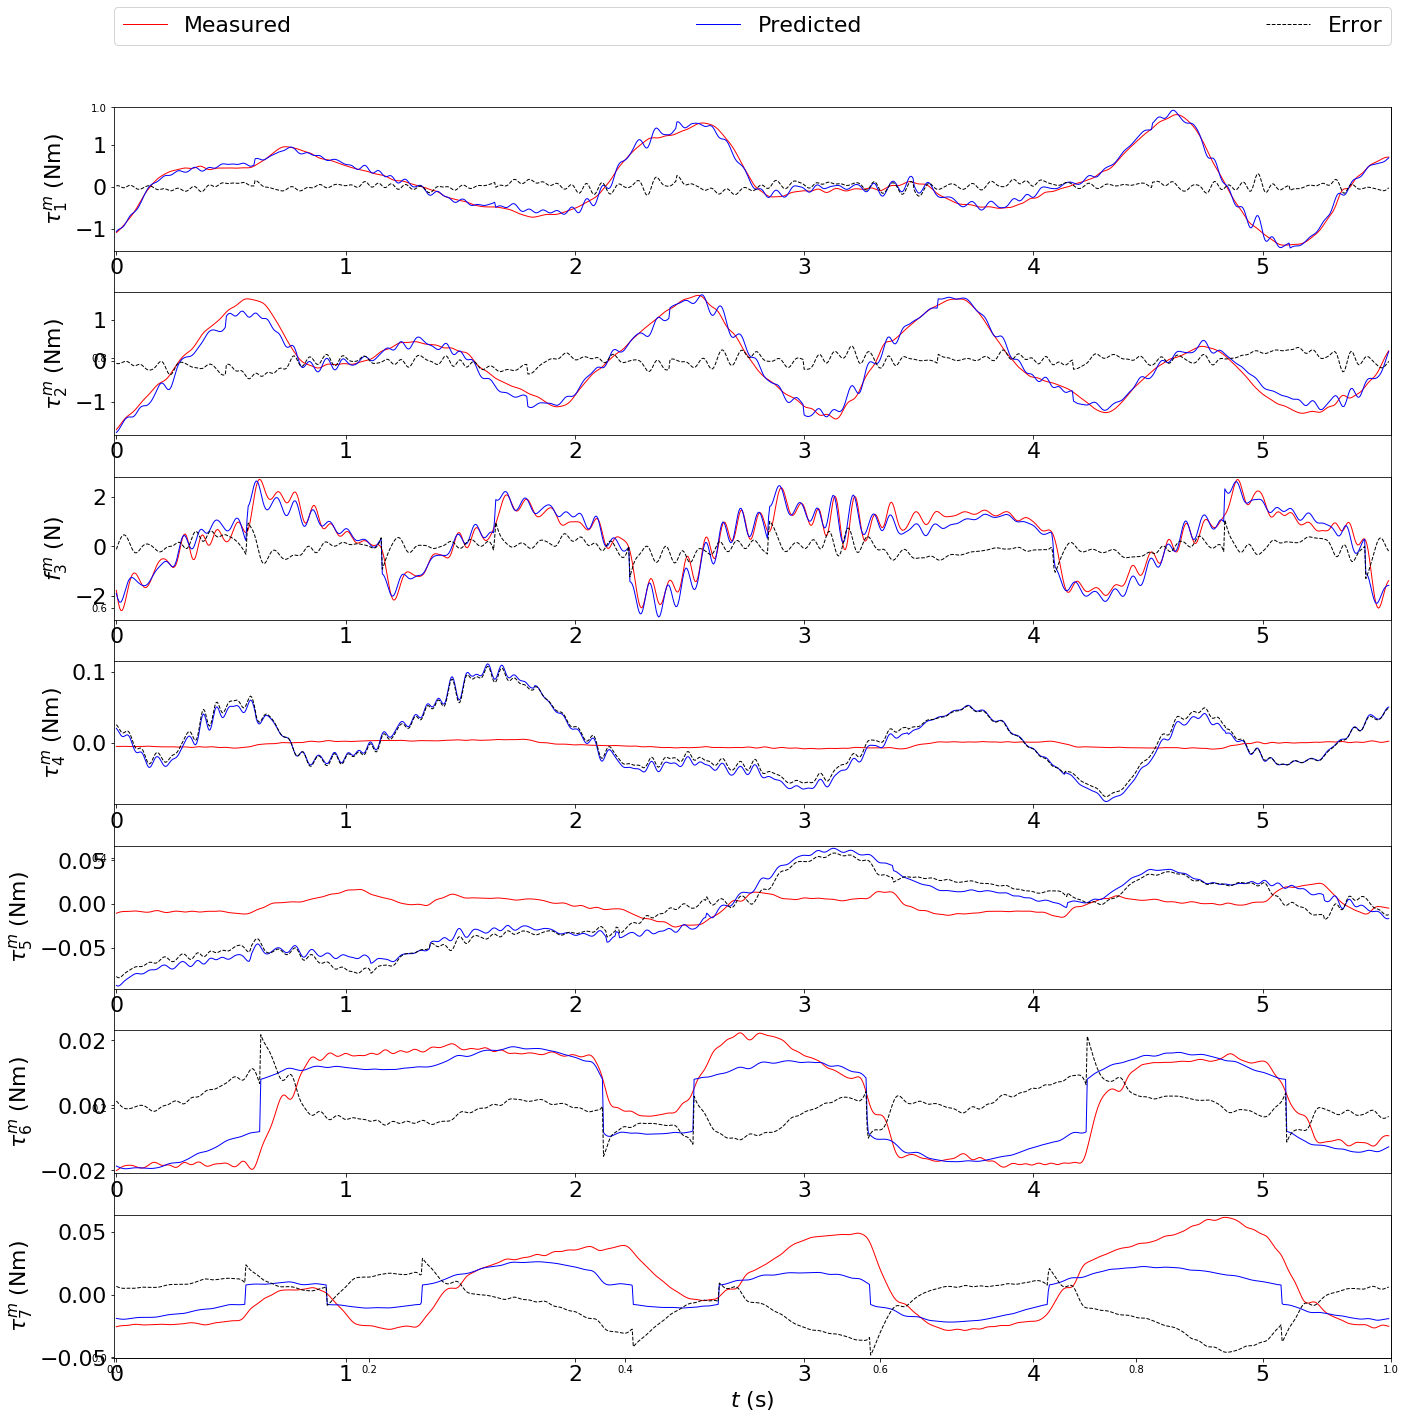

In [19]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [20]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.11420462, 0.16988998, 0.24868438, 7.99081472, 4.00707478,
       0.37452349, 0.63677707])

## Weighted Least Square (WLS)

### Training data set

In [21]:
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([3.17015465, 2.57786851, 6.47078822, 0.01966438, 0.07537457,
       0.04577706, 0.06740394])

In [22]:
W_b_train.shape, tau_s_train.shape

In [23]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [24]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [25]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

In [26]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                  -0.2⋅l2y + 0.2⋅l5y + 1.0⋅l6
⎢                                                                             
⎢                                                   

In [27]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

('Avarage error of joint ', 1, ': ', 0.05240245102382921)
('Avarage error of joint ', 2, ': ', 0.09005565926109338)
('Avarage error of joint ', 3, ': ', 0.19379402489973752)
('Avarage error of joint ', 4, ': ', 0.0014221797728979709)
('Avarage error of joint ', 5, ': ', 0.008021837825612638)
('Avarage error of joint ', 6, ': ', 0.004355309783504915)
('Avarage error of joint ', 7, ': ', 0.008146630770390706)
('Avarage of error: ', 0.05117115619100948)


<Figure size 432x288 with 0 Axes>

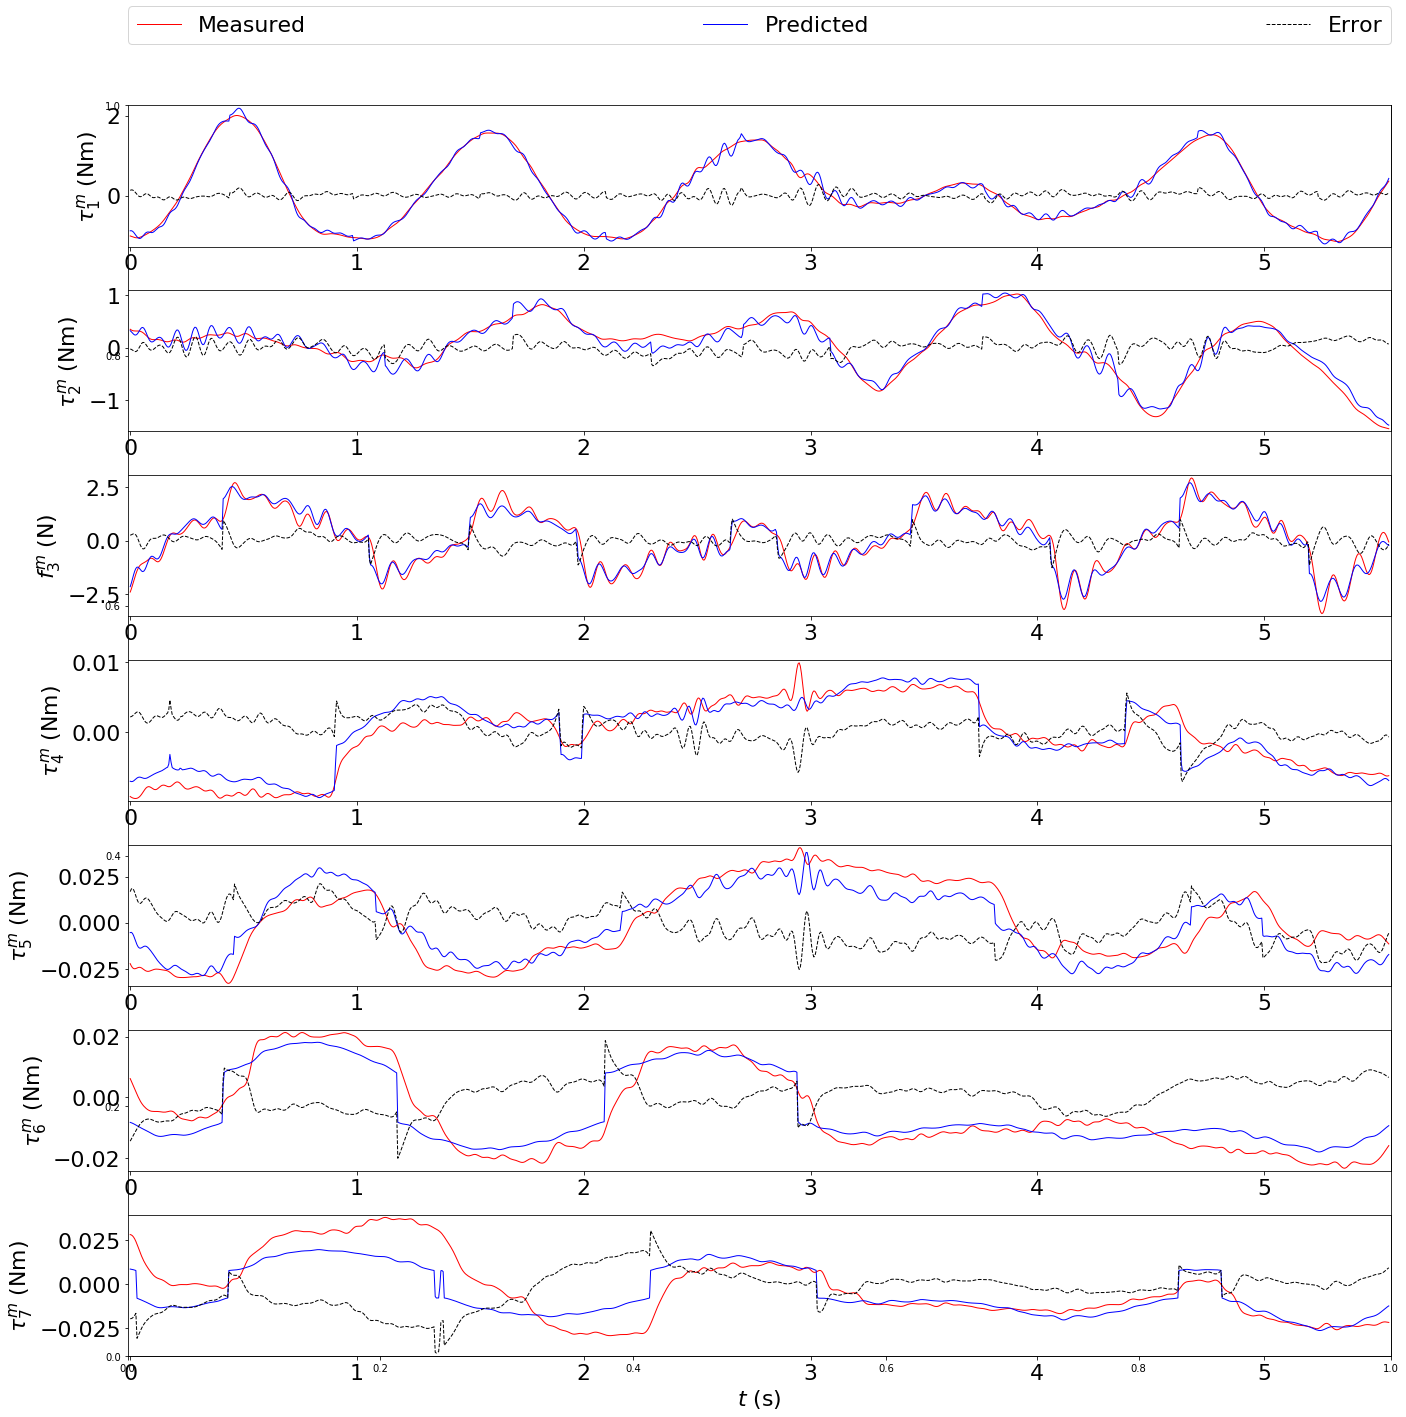

In [28]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)

In [29]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07970291, 0.21396184, 0.20868992, 0.36560981, 0.47743672,
       0.35004428, 0.592099  ])

### Test data set

('Avarage error of joint ', 1, ': ', 0.06453507117691049)
('Avarage error of joint ', 2, ': ', 0.11228461567375539)
('Avarage error of joint ', 3, ': ', 0.24070875308752082)
('Avarage error of joint ', 4, ': ', 0.004562166082184103)
('Avarage error of joint ', 5, ': ', 0.010665465156157355)
('Avarage error of joint ', 6, ': ', 0.0041506626310589675)
('Avarage error of joint ', 7, ': ', 0.014655022360581894)
('Avarage of error: ', 0.06450882230973844)


<Figure size 432x288 with 0 Axes>

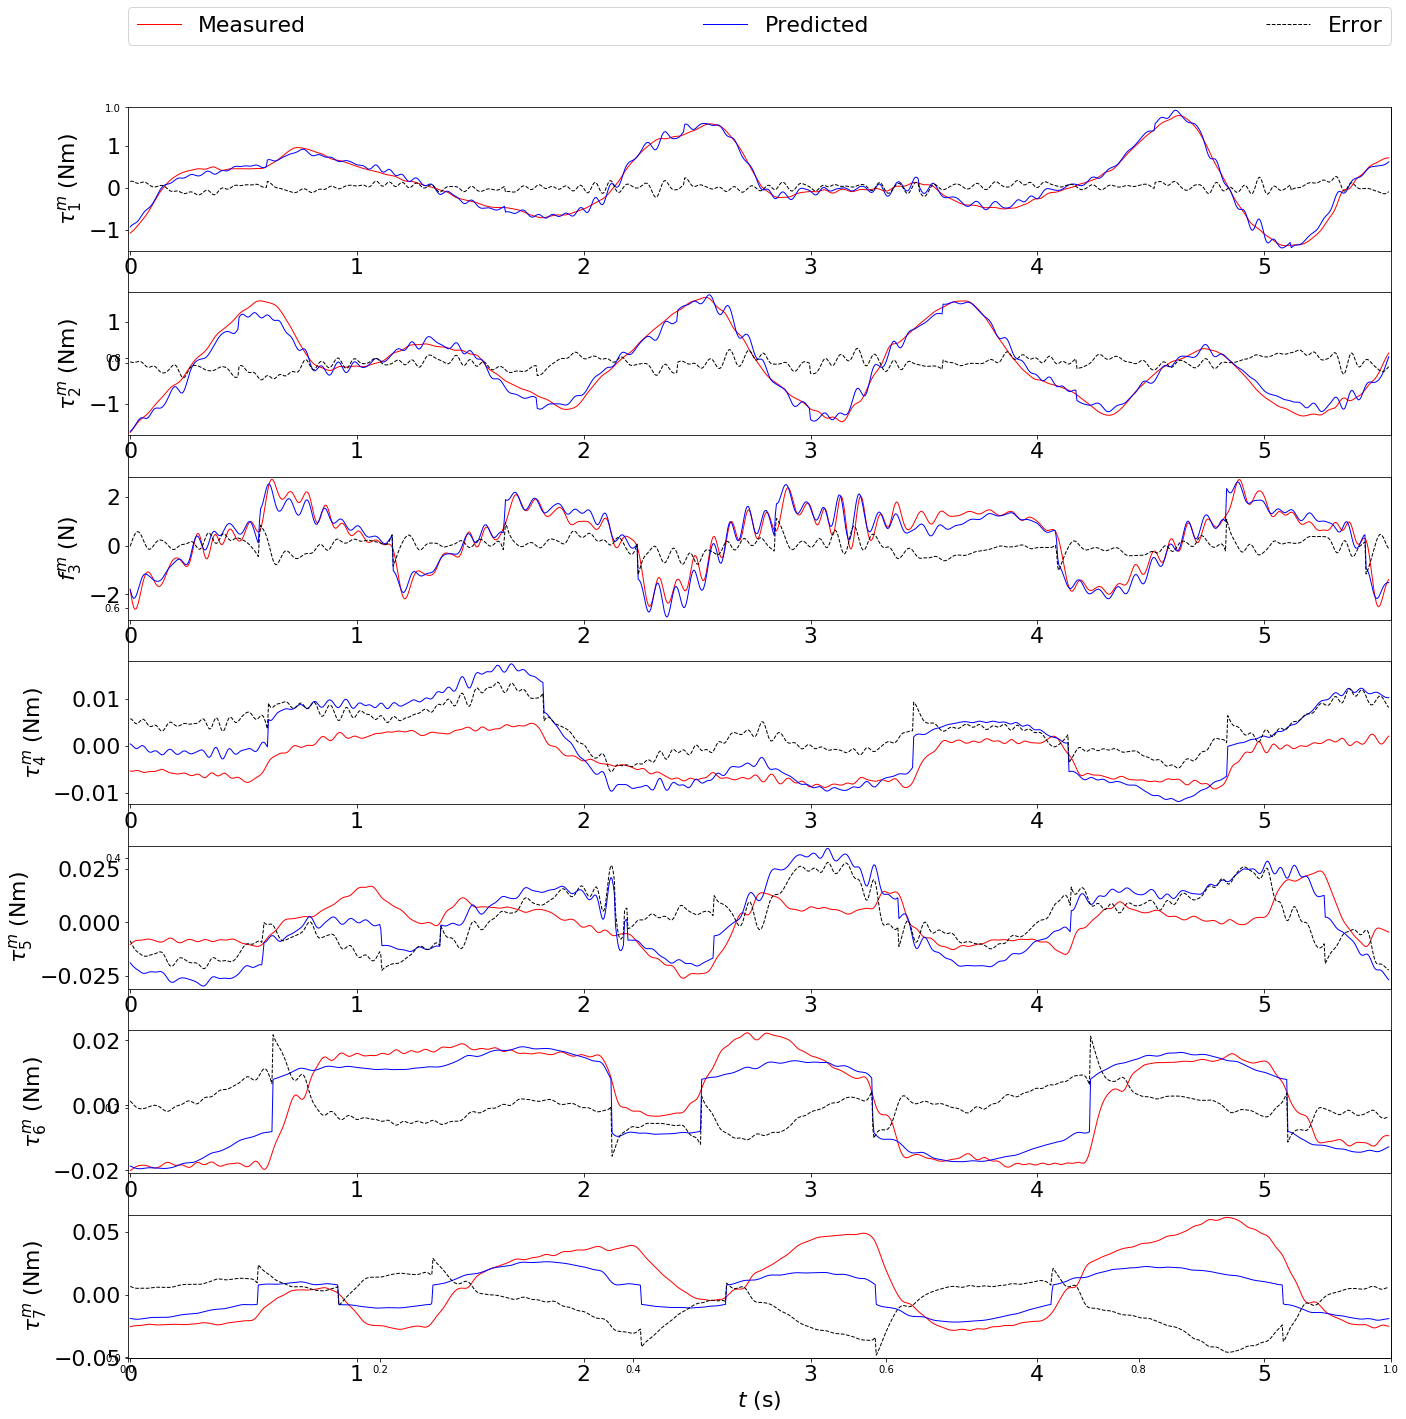

In [30]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [31]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.11326128, 0.17115418, 0.25172532, 1.11974041, 1.28093539,
       0.37452349, 0.63677707])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [51]:
from identification import SDPOpt
from identification import ALPSOOpt


bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [52]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

min $m$, max $m$, min $r_x$, max $r_x$, min $r_y$, max $r_y$, min $r_z$, max $r_z$, max $F_c$, max $F_v$, max $F_o$, min $K$, max $K$

In [53]:
alpso_constraints = []
spring_constraints = []


if model_name == 'psm':
    alpso_constraints = [(0.3,  10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.3, 0.3472, 0, 1, 0.0001, 1), 
                      (0.02,   10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.3, 0.5419, 0.2542, 1, 0.0001, 1),    
                      (0,      0,     0,    0,     0,    0,    0,   0,   0, 0, 0, 0, 0, 0), 
                      (0.01,   5, -0.2, 0.3, -0.2, 0.2, -0.2, 0.2, 0.3, 5, 5, 1, 0, 0), 
                      (0.01,   5, -0.2, 0.4, -0.2, 0.2, -0.2, 0.3, 0.3, 5, 5, 1, 0, 0), 
                      (0.01,   5, -0.2, 0.5, -0.4, 0.2, -0.2, 0.8, 0.3, 1.5508, 0, 1, 0, 0), 
                      (0.01,   5, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.2, 5, 5, 1, 0, 0),
                      (0.01,   2, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.3, 0.0015, 0, 1, 0.0001, 1),
                      (0.001,  1, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 0.838, 5, 0, 1, 0, 0), 
                      (0.001,  1, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 0.2, 0.0501, 0, 1, 0, 0),
                      (0,      1, -0.05, 0.05, -0.05, 0.05, -0.1, 0.1, 0.2, 5, 0.017, 1, 0, 0)]   
    
else:
    raise Exception("No robot name matches " + model_name)

In [80]:
from identification import SDPOpt

sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model, alpso_constraints)
%time sdp_opt_std.solve(20000)

ImportError: cannot import name SDPOp

In [81]:
from identification import ALPSOOpt

sdp_opt_std = ALPSOOpt(W_w_train, tau_w_s_train, robot_model, alpso_constraints)
%time sdp_opt_std.solve()

Regressor shape: (39193, 112)
Regressand shape: (39193,)


AttributeError: ALPSOOpt instance has no attribute '_create_var'

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [36]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [37]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.0805926 , 0.24034442, 0.38691799, 0.36612354, 0.4750904 ,
       0.35004075, 0.59209823])

### Plot measured torque and predicted torque

('Avarage error of joint ', 1, ': ', 0.052452735070723185)
('Avarage error of joint ', 2, ': ', 0.10082141275249211)
('Avarage error of joint ', 3, ': ', 0.41288136259078534)
('Avarage error of joint ', 4, ': ', 0.001420249600550553)
('Avarage error of joint ', 5, ': ', 0.008003517103749747)
('Avarage error of joint ', 6, ': ', 0.004355200488154005)
('Avarage error of joint ', 7, ': ', 0.008146636376727398)
('Avarage of error: ', 0.08401158771188318)


<Figure size 432x288 with 0 Axes>

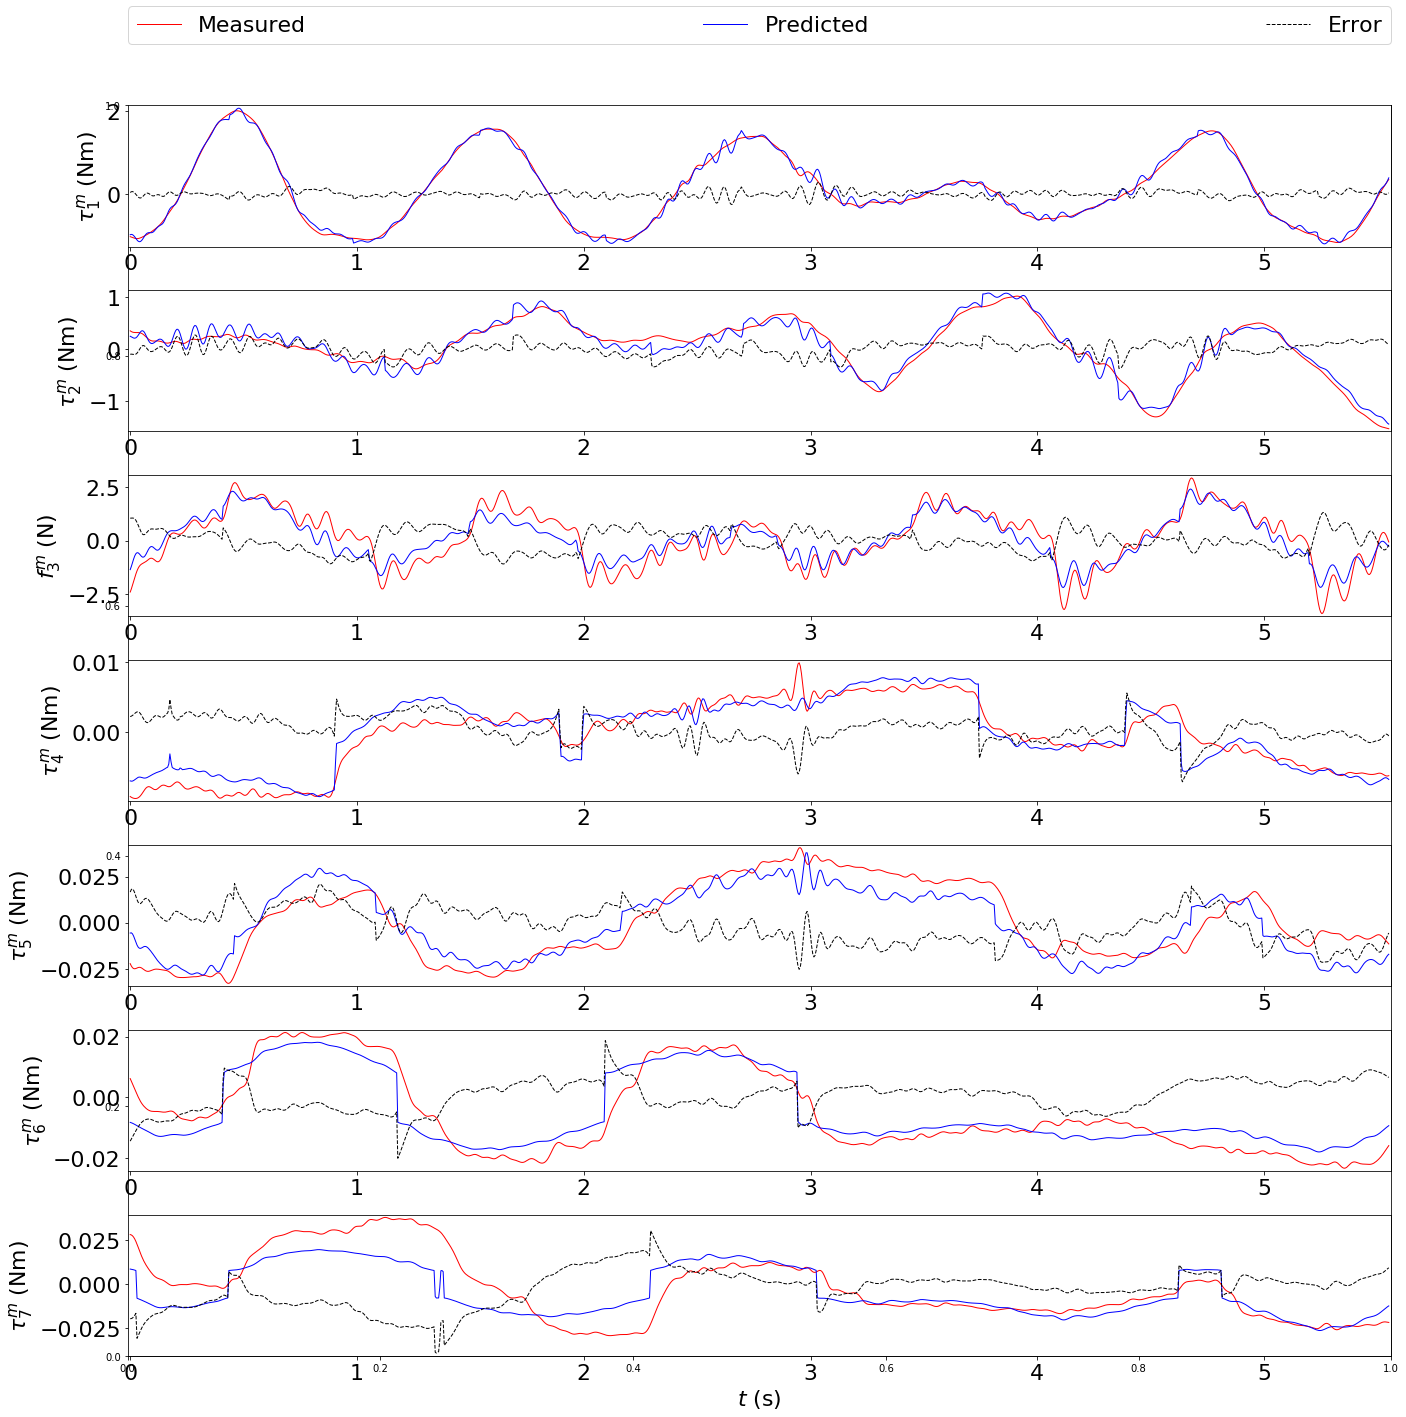

In [38]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [39]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

('Avarage error of joint ', 1, ': ', 0.07134339724209905)
('Avarage error of joint ', 2, ': ', 0.11691016625048287)
('Avarage error of joint ', 3, ': ', 0.4237177197726134)
('Avarage error of joint ', 4, ': ', 0.004445099755306379)
('Avarage error of joint ', 5, ': ', 0.010599889504602845)
('Avarage error of joint ', 6, ': ', 0.0041506592936663474)
('Avarage error of joint ', 7, ': ', 0.014654847649912428)
('Avarage of error: ', 0.0922602542098119)


<Figure size 432x288 with 0 Axes>

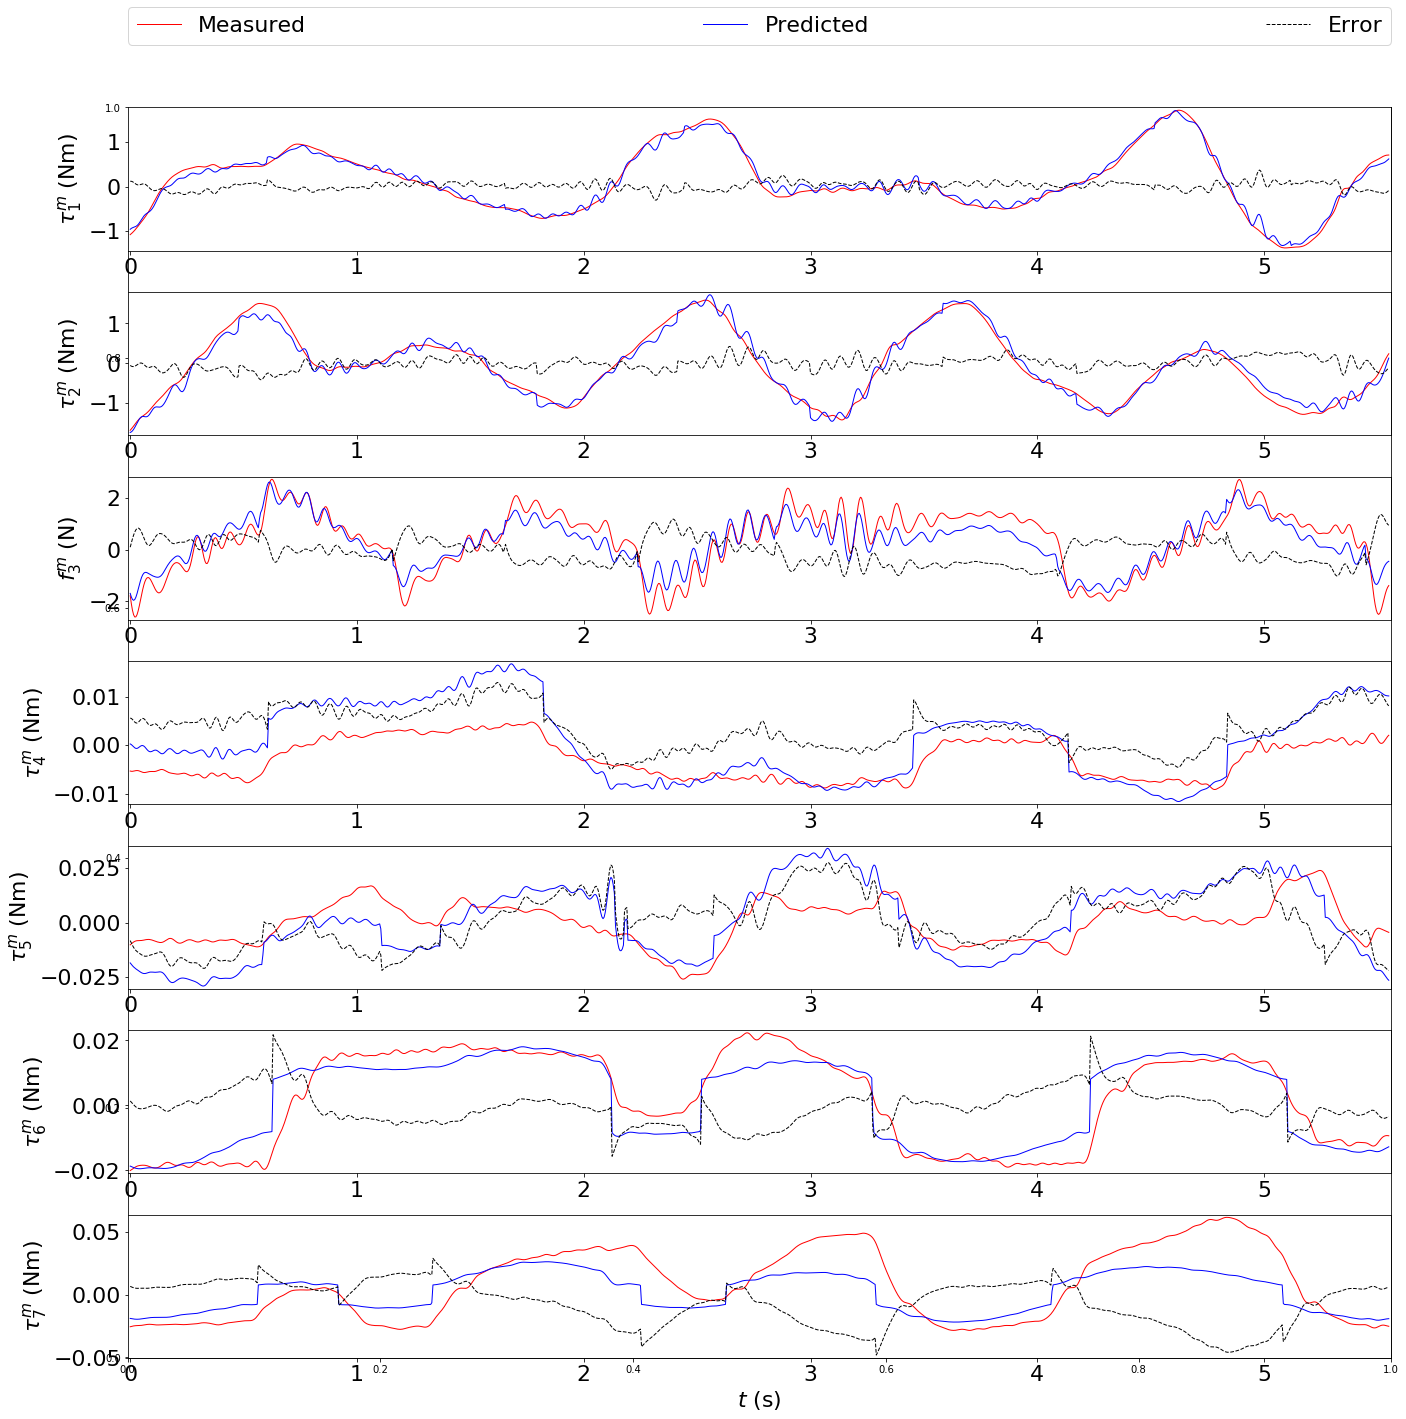

In [40]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [41]:
test_plot_data_folder = 'data/' + model_name +'/test_plot_data_folder/'
test_plot_data = (t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)
save_data(test_plot_data_folder, test_trajectory_name, test_plot_data)

In [42]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.12562691, 0.17711177, 0.40110494, 1.09405626, 1.27133295,
       0.37452274, 0.63677192])

In [43]:
from identification import params_array2table
x_bary_round= np.around(sdp_opt_std.x_result, decimals=7)
bary_param_table = params_array2table(x_bary_round, robot_model, 'bary')
# sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))
bary_param_table

⎡link     Lₓₓ         L_xy        L_xz        L_yy        L_yz        L_zz    
⎢                                                                             
⎢ 1    1.1374135    8.86e-5       0.0       1.13842       0.0      0.0014364  
⎢                                                                             
⎢ 2    0.0274389   -0.0130709  -0.0024024  0.0087376   -0.0055189   0.03353   
⎢                                                                             
⎢ 3        0           0           0           0           0           0      
⎢                                                                             
⎢ 4    0.0055731   -0.0001584  -0.0001517  8.8199247   -0.0025763  8.8201476  
⎢                                                                             
⎢ 5    0.1705428   -0.0515935  -0.0001769  0.0165992   0.0007062   0.1867227  
⎢                                                                             
⎢ 6    0.0039488   0.0013215   0.0001671   0.0009825

### Base parameters

In [44]:
robot_model.base_param[0,0]
subs_x_result2bary = [(sym, x) for sym, x in zip(robot_model.bary_param, sdp_opt_std.x_result)]

sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(sympy.Matrix(robot_model.base_param).subs(subs_x_result2bary)))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                  -0.2⋅l2y + 0.2⋅l5y + 1.0⋅l6
⎢                                                                             
⎢                                                   

In [45]:
from identification import barycentric2standard_params

In [46]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)
s_round_std = np.round(np.array(x_std).astype(np.float), decimals=7)

In [47]:
std_param_table = params_array2table(s_round_std, robot_model, 'std')
#sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))
std_param_table

⎡link     Iₓₓ         I_xy        I_xz        I_yy        I_yz        I_zz    
⎢                                                                             
⎢ 1    1.1374057      0.0         0.0      1.1374062      0.0       0.000415  
⎢                                                                             
⎢ 2    0.0003014   0.0002337   0.0003526   0.0008195   -0.0001307  0.0007058  
⎢                                                                             
⎢ 3        0           0           0           0           0           0      
⎢                                                                             
⎢ 4    0.0004159     1.0e-7      1.0e-7    8.8174482    -1.0e-7    8.8174482  
⎢                                                                             
⎢ 5    0.0003035   0.0002348   -0.0003519  0.0008183   0.0001314   0.0007064  
⎢                                                                             
⎢ 6    0.0003064    0.000356   0.0002333   0.0007083

### Write identified dynamic parameters into a JSON file

In [48]:
Rs = [np.matrix(R.evalf(subs={q1: 0, q2: 0, q3: 0, q4: 0, q5: 0, q6: 0, q7: 0})).astype(np.float64)
      for R in robot_model.R[1:]]
x_std_base_frame = barycentric2standard_params(sdp_opt_std.x_result, robot_model, Rs)
x_round_std_base_frame = np.round(np.array(x_std_base_frame).astype(np.float), decimals=7)
std_param_base_frame_table = params_array2table(x_round_std_base_frame, robot_model, 'std')
std_param_base_frame_table

⎡link     Iₓₓ        I_xy       I_xz        I_yy        I_yz        I_zz      
⎢                                                                             
⎢ 1    1.1374062      0.0        0.0      0.000415      0.0      1.1374057   -
⎢                                                                             
⎢ 2    0.0007058   0.0003526  0.0001307  0.0003014   -0.0002337  0.0008195   0
⎢                                                                             
⎢ 3        0           0          0          0           0           0        
⎢                                                                             
⎢ 4    8.8174482    -1.0e-7    -1.0e-7   0.0004159    -1.0e-7    8.8174482   0
⎢                                                                             
⎢ 5    0.0007064   0.0003519  0.0001314  0.0003035   -0.0002348  0.0008183    
⎢                                                                             
⎢ 6    0.0007083   0.000356   0.000132   0.0003064  

In [49]:
from identification import write_parameters2json
param_folder = 'data/' + model_name +'/dynamic_params/'
std_param_name = 'params'
std_param_name2 = training_trajectory_name_
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name)
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name2)

Parameters have been written into [data/psm/dynamic_params/params.json] successfully!
Parameters have been written into [data/psm/dynamic_params/onyeditr.json] successfully!
